# 3D DEEP LEARNING

In this notebook we'll:
1. Process a 3D Point Cloud Dataset
2. Visualize the Dataset in 3D
3. Build a 3D Deep Learning Model
4. Test on new data

The code has been adapted from Intel's version for education purpose: https://github.com/intel-isl/Open3D-PointNet


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremy26/3d-deep-learning/blob/main/3D%20Deep%20Learning/3D_DL_Starter_Hardcore.ipynb)

# Dataset

We are going to work with the ShapeNet Dataset. This dataset provides part segmentation to a subset of ShapeNetCore models, containing ~16K models from 16 shape categories. The number of parts for each category varies from 2 to 6 and there are a total number of 50 parts.
<p>
The folder structure is as below:

* synsetoffset
    * **points:** uniformly sampled points from ShapeNetCore models
    * **point_labels:** per-point segmentation labels
    * **seg_img:** a visualization of labeling
* **train_test_split:** lists of training/test/validation shapes shuffled across all categories (from the official train/test split of ShapeNet)

The ShapeNet Dataset comes from Standford and will allow us to do both Classification and Segmentation.<p>

In [1]:
 ### Link Google Colab to Google Drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

work_dir = "/content/drive/My Drive/Autonomous Projects/3d-deep-learning/"
os.chdir(work_dir)
!ls

Mounted at /content/drive
3D_DL_Starter_Hardcore.ipynb  my_cls
cls			      __pycache__
datasets.py		      shapenetcore_partanno_segmentation_benchmark_v0
Keras_PointNet.ipynb


## Download the Dataset

In [ ]:
# Run this only if you don't already have the Dataset on Google Drive
HAVE_DATASET = True
if not HAVE_DATASET:
    import requests 
    import wget
    file_url = "https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip"
    !wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
    !unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
    !rm shapenetcore_partanno_segmentation_benchmark_v0.zip

In [ ]:
# !ls shapenetcore_partanno_segmentation_benchmark_v0/02691156/points_label

In [ ]:
# Avoid an SSL Error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Imports
We'll need a few things to get started:
* Open3D: A Point Cloud Library; we'll use it for Visualization - We use version 12
* PyTorch: A Deep Learning Library - We Use version 1.7
* All the other usual libraries (numpy, matplotlib, random, ...)

In [2]:
# Do this if you don't have Open3D
HAVE_OPEN3D = False
if not HAVE_OPEN3D:
    !pip install open3d==0.12.0 # Version 12
    !pip install progressbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188.4 MB 47 kB/s 
     |████████████████████████████████| 1.6 MB 56.9 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=8f81a9c0d9b310afa991afa68c3e8acfadd8fce057d892d19c8e601bec9687ba
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=f562b1586c4cbae3bb3181366c2d85fa36c1a04b9c05c0ebe778ae9f3c5562f9
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [3]:
# Usual Imports
from __future__ import print_function
import os
import random
from random import randrange
from IPython.display import clear_output
from PIL import Image
import os.path
import errno
import json
import codecs
import numpy as np
import progressbar
import sys
import matplotlib.pyplot as plt

# Open3D Imports
import open3d as o3
print(o3.__version__)
from open3d import JVisualizer # Useful for Jupyter Notebook Visualization

# PyTorch Imports
import torch # Version 1.7.0 is the one used in the project
print(torch.__version__)
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

0.12.0
1.12.1+cu113


## Preprocess the 3D Point Cloud Dataset

In [4]:
# General parameters
NUM_POINTS = 10000

DATA_FOLDER = work_dir + 'shapenetcore_partanno_segmentation_benchmark_v0'

In [5]:
class PartDataset(torch.utils.data.Dataset):
    """
    This preprocesses the dataset.
    """
    # TODO: Add a visualization of the segmentation image and return it.
    def __init__(self, root, npoints = 2500, classification = False, class_choice = None, train = True, image=False):
        self.npoints = npoints # number of points
        self.root = root # root folder
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt') # category file
        self.cat = {}
        self.image = image # Dataset contains an image or not
        self.classification = classification
        # Open the Category File and Map Folders to Categories
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        # print(self.cat)
        
        # Select categories from the dataset, e.g. call in parameters "class_choice=["Airplane"]
        if not class_choice is None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}
        
        # For every item in a specific category, assign the point, segmentation, and image.
        self.meta = {}        
        for item in self.cat:
            # Read the dataset and store the labels.
            # print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            dir_seg_img = os.path.join(self.root, self.cat[item], 'seg_img')
            
            # fns: list of filenames of points ".pts" in descending order
            fns = sorted(os.listdir(dir_point))
            if train:
                fns = fns[:int(len(fns) * 0.9)]
            else:
                fns = fns[int(len(fns) * 0.9):]

            
            for fn in fns: # FOR EVERY POINT CLOUD FILE
                # token: name of point file without ".pts"
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta[item].append((os.path.join(dir_point, token + '.pts'), # points
                                        os.path.join(dir_seg, token + '.seg'), # segmentation points
                                        os.path.join(dir_seg_img, token + '.png'))) # segmentation image

        # Create a Variable where you have (item, points, segmentation points, segmentation image)
        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1], fn[2]))

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        # print(self.classes)
        
        self.num_seg_classes = 0
        if not self.classification: # Take the Segmentation Labels
            for i in range(len(self.datapath)//50):
                # print(np.loadtxt(self.datapath[i][-2]))
                l = len(np.unique(np.loadtxt(self.datapath[i][-2]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l
        # print(self.num_seg_classes)

In [6]:
def __getitem__(self, index):
    '''
    This will be used to pick a specific element from the dataset.
    self.datapath is the dataset.
    Each element is under format "class, points, segmentation labels, segmentation image"
    '''
    # Get one Element
    fn = self.datapath[index]
    # print(fn)
    
    # get its Class
    cls = self.classes[fn[0]]
    # print(cls)
    
    # Read the Point Cloud
    point_set = np.asarray(o3.io.read_point_cloud(fn[1], format='xyz').points,dtype=np.float32)
    
    # Read the Segmentation Data
    seg = np.loadtxt(fn[2]).astype(np.int64)

    # print(point_set.shape, seg.shape)
    
    # Read the Segmentation Image
    import imageio
    image = imageio.imread(fn[3])

    choice = np.random.choice(len(seg), self.npoints, replace=True)
    
    #resample
    point_set = point_set[choice, :]        
    seg = seg[choice]
    point_set = torch.from_numpy(point_set)
    seg = torch.from_numpy(seg)
    cls = torch.from_numpy(np.array([cls]).astype(np.int64))
    
    if self.classification:
        if self.image:
            return point_set, cls, image
        else:
            return point_set, cls

    else:
        if self.image:
            return point_set, seg, image
        else:
            return point_set, seg

def __len__(self):
    return len(self.datapath)

PartDataset.__getitem__ = __getitem__
PartDataset.__len__ = __len__

In [7]:
# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

## Visualize the Dataset in 3D with Open3D

In [8]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0], # green
        2: [0, 0, 255], # blue
        3: [255, 0, 0], # red
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

Number of objects 15990
----------
Point Cloud Caracteristics:
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor
----------
Point Cloud
tensor([[ 0.2408, -0.0524, -0.0350],
        [ 0.1977, -0.0203,  0.0229],
        [ 0.0416, -0.0779, -0.0319],
        ...,
        [-0.0267, -0.0499, -0.2384],
        [ 0.0172, -0.0627,  0.0341],
        [-0.2699, -0.0292, -0.0198]])
----------
Label on Part Segmentation
tensor([1, 1, 2,  ..., 2, 1, 1])
----------
Label on Classification
Airplane


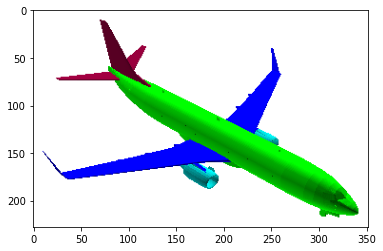

In [9]:
# Default parameters for PartDataset: npoints = 2500, classification = False, class_choice = None, train = True, image=False

# Get a Dataset for segmentation and with the image you got
d = PartDataset(root=DATA_FOLDER, image=True)
print("Number of objects", len(d))
print('----------')

idx = random.randint(0,len(d))
ps, seg, img = d[idx]

print("Point Cloud Caracteristics:")
print(ps.size(), ps.type(), seg.size(), seg.type())
print('----------')
print("Point Cloud")
print(ps)
print('----------')
print("Label on Part Segmentation")
print(seg)
print('----------')

# Get a Dataset for Classification with the same index and without the image
d = PartDataset(root=DATA_FOLDER, classification=True, image=False)
ps2, cls = d[idx]

print("Label on Classification")
classes_dict_list = list(classes_dict)
print(classes_dict_list[cls.item()])

plt.imshow(np.asarray(img))

In [28]:
from google.colab import output
output.enable_custom_widget_manager()

In [30]:
from open3d import JVisualizer
test_vis = JVisualizer()
test_vis.clear()
clear_output()
test_cloud = o3.geometry.PointCloud()
test_cloud.points = o3.utility.Vector3dVector(ps)
test_cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

test_vis.add_geometry(test_cloud)
test_vis.show()

JVisualizer with 1 geometries

### Visualise with Plotly

In [31]:
import plotly.graph_objects as go

In [33]:
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        
        if geometry_type == o3.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)
            
            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)
        
    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

o3.visualization.draw_geometries = draw_geometries # replace function
o3.visualization.draw_geometries([test_cloud])
# o3.visualization.draw_geometries([mesh])

# 3D Deep Learning Model: PointNet

## Build the Model: PointNet


![PointNet](https://miro.medium.com/max/1400/1*6ovpVlWKU3ZKk2OT_WKZHA.png)


**PointNet Architecture.** The classification network takes n points as input, applies input and feature transformations, and then aggregates point features by max pooling. The output is  scores for k classes. The segmentation network is an extension to the classification net. It concatenates global and local features and outputs per point scores. “mlp” stands for multi-layer perceptron, numbers in bracket are layer sizes. Batchnorm is used for all layers with ReLU. Dropout layers are used for the last mlp in classification net

It's coming from the paper: https://arxiv.org/pdf/1612.00593.pdf

To learn more about the theory behind PointNet look at this [blog](https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a).

### Build the T-Net

T-Net takes raw point cloud and regresses to a $k × k$ matrix.

Architecture:
* Shared MLP(64, 128, 1024) for each point (Shared MLP means 1-dim convolution with a kernel of size 1)
* Max pooling accross all points 
* Two FC layers of size (512, 256)
* All layers except the last one include ReLU and batch normalisation

In [12]:
class T_Net(nn.Module):
    """
    T-Net Model. 
    """
    def __init__(self, num_points = 2500, k = 3):
        super().__init__()
        self.num_points = num_points
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1) # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.mp1 = nn.MaxPool1d(num_points)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        # x.size = (batchsize, n, 3)
        batchsize = x.size(0)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # Run max pooling over x
        x = self.mp1(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))

        # Convert to a kxk matrix
        x = self.fc3(x)
        x = x.view(-1, self.k, self.k)

        # Output matrix initialised as the identity matrix
        iden = torch.eye(self.k, requires_grad=True, device=x.device).repeat(batchsize,1,1)

        x = x + iden
        return x

### Build the Transformer

The transformer outputs the local and global features of the point cloud as displayed on the diagram above.

In [13]:
class Transform(nn.Module):
    """
    Part of Classification Network that outputs the local and global features
    """
    def __init__(self, num_points = 2500):
        super().__init__()
        self.num_points = num_points
        self.input_transform = T_Net(num_points=num_points, k=3)
        self.conv1 = nn.Conv1d(3, 64, 1)
        
        self.feature_transform = T_Net(num_points=num_points, k=64)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.mp1 = nn.MaxPool1d(num_points)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        # x.size = (batchsize, n, 3)
        matrix3x3 = self.input_transform(x)
        # Batch Matrix multiplication: x [32, 3, n_points], matrix3x3 [32, 3, 3]
        x = torch.bmm(torch.transpose(x, 1, 2), matrix3x3).transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))

        matrix64x64 = self.feature_transform(x)
        # Batch Matrix multiplication: x [32, 64, n_points], matrix3x3 [32, 64, 64]
        local_features = torch.bmm(torch.transpose(x, 1, 2), matrix64x64).transpose(1, 2)
        # print("local_features", local_features.size())
        x = F.relu(self.bn2(self.conv2(local_features))) # (64, 128, 1)
        x = self.bn3(self.conv3(x)) # (128, 1024, 1)

        x = self.mp1(x)
        global_features = torch.flatten(x, 1)

        return global_features, local_features

sim_data = Variable(torch.rand(32,3,2500))
trans = Transform()
out, _ = trans(sim_data)
print('global feat', out.size())

global feat torch.Size([32, 1024])


### Build the Classification Head

![ClassificationHead](https://i.stack.imgur.com/0brAS.jpg)


In [14]:
class PointNetCls(nn.Module):
    """
    Network for Classification: 512, 256, n_classes.
    """
    def __init__(self, num_points = 2500, n_classes = 1):
        super(PointNetCls, self).__init__()
        self.num_points = num_points
        self.n_classes = n_classes

        self.trans = Transform()

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)
        # self.dropout = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(n_classes)

        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # x.size = (batchsize, n, 3)
        global_features, local_features = self.trans(x)

        x = F.relu(self.bn1(self.fc1(global_features)))
        # x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.bn3(self.fc3(x))

        output_scores_cls = self.logsoftmax(x)
        return output_scores_cls, global_features, local_features

In [15]:
cls = PointNetCls(n_classes = 5)
out, _, _ = cls(sim_data)
print('class', out.size())

class torch.Size([32, 5])


### Build the Segmentation Head

In [16]:
class PointNetSeg(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points = 2500, n_classes = 2):
        super(PointNetSeg, self).__init__()
        self.num_points = num_points
        self.n_classes = n_classes
        
        self.cls = PointNetCls(num_points=num_points, n_classes=n_classes)
        # Change m if the length of global_features + local_features changes.
        m = 1088 
        self.conv1 = nn.Conv1d(m, 512, 1)
        self.conv2 = nn.Conv1d(512, 256, 1)
        self.conv3 = nn.Conv1d(256, 128, 1)
        self.conv4 = nn.Conv1d(128, n_classes, 1)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        # self.bn4 = nn.BatchNorm1d(n_classes)

        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # x.size = (batchsize, n, 3)
        _, global_features, local_features = self.cls(x)
        global_features = torch.flatten(global_features, 1).repeat(self.num_points, 1, 1).transpose(0, 2).transpose(0, 1)
        # print("local_features", local_features.size())
        # print("global_features", global_features.size())
        stack = torch.cat((local_features, global_features), 1)
        
        # stack.size = (batchsize, 1088, 2500)
        x = F.relu(self.bn1(self.conv1(stack)))
        x = F.relu(self.bn2(self.conv2(x)))
        point_features = F.relu(self.bn3(self.conv3(x)))
        # x = self.bn4(self.conv4(point_features))
        x = self.conv4(point_features)

        output_scores_seg = self.logsoftmax(x)
        return output_scores_seg, point_features

sim_data = Variable(torch.rand(32, 3, 2500))
seg = PointNetSeg(n_classes = 3)
out, _ = seg(sim_data)
print('seg', out.size())

seg torch.Size([32, 3, 2500])


In [17]:
seg = PointNetSeg(n_classes = 3)
print(seg)
out, _ = seg(sim_data)
print('seg', out.size())

PointNetSeg(
  (cls): PointNetCls(
    (trans): Transform(
      (input_transform): T_Net(
        (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
        (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
        (fc1): Linear(in_features=1024, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (fc3): Linear(in_features=256, out_features=9, bias=True)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn5): BatchNorm1d(256, ep

## Train the Model for classification

Hyperparameters:

- [x] Regularisation loss $λ$ = 0.001 (`weight_decay`)
- [x] Dropout ratio = 0.7 on the last FC layer (256).
- [ ] Decay rate of batch normalisation goes from 0.5 to 0.99
- [x] Adam optimiser with initial learning rate 0.001
- [ ] Momentum 0.5
- [x] Batch Size 32
- [x] Learning rate divided by 2 for every 20 epochs.

In [18]:
# Define Hyperparameters
batchSize = 32
num_points = 2500
workers = 4
nepoch = 25
outf = work_dir + "my_cls" # Out folder, saving model after each epoch
learning_rate = 0.001
momentum = 0.5
weight_decay = 1e-3

In [23]:
import tqdm
# DATASET & DATA LOADER
torch.manual_seed(0)
TRAIN_MODEL = False
# Train Dataset & DataLoader
dataset = PartDataset(root = DATA_FOLDER, classification = True, train = True, npoints = num_points, image=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

# Test Dataset & DataLoader
test_dataset = PartDataset(root = DATA_FOLDER, classification = True, train = False, npoints = num_points, image=False)
testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

blue = lambda x:'\033[94m' + x + '\033[0m'

# CALL THE MODEL
num_classes = len(classes_dict.items())

classifier = PointNetCls(num_points = num_points, n_classes = num_classes)

optimizer = torch.optim.Adam(classifier.parameters(),
                             lr=learning_rate,
                             # momentum=momentum,
                             weight_decay=weight_decay)
if torch.cuda.is_available():
    classifier.cuda()

num_batch = len(dataset)/batchSize

# TRAIN ON EPOCHS
if TRAIN_MODEL:
    for epoch in range(nepoch):
        with tqdm.tqdm(dataloader, unit="batch") as tepoch: 
            for i, data in enumerate(tepoch):
                """
                Get Points & Classification Label
                """
                classifier.train()
                points, target = data
                # The target tensor is supposed to be 1D so it works when computing the NLL loss
                target = target[:, 0]
                # print("target_v2", target)
                if torch.cuda.is_available():
                    points, target = points.cuda(), target.cuda()
                
                # Zero out all of the gradients for the variables which the optimizer will update.
                optimizer.zero_grad()
                
                # Train
                # classifier = None
                # print(points.size())
                pred, _, _  = classifier(points.transpose(1,2))
                # Define NLL Loss and Backpropagate

                nll_loss = nn.NLLLoss()
                output = nll_loss(pred, target)
                output.backward()


                pred_choice = torch.max(pred, dim=1)[1]
                correct = pred_choice.eq(target.data).cpu().sum()
                print('[%d: %d/%d] train loss: %f accuracy: %f' %(epoch, i, num_batch, output.item(), correct.item() / float(batchSize)))

                # Update the parameters of the model using the gradients
                optimizer.step()

                if i % 10 == 0:
                    j, test_data = next(enumerate(testdataloader, 0))
                    points, target = test_data
                    target = target[:, 0]
                    if torch.cuda.is_available():
                        points, target = points.cuda(), target.cuda()
                    classifier = classifier.eval()
                    pred, _, _ = classifier(points.transpose(1,2))
                    loss = nll_loss(pred, target)
                    pred_choice = torch.max(pred, dim=1)[1]
                    correct = pred_choice.eq(target.data).cpu().sum()
                    print('[%d: %d/%d] %s loss: %f accuracy: %f' %(epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(batchSize)))

        torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (outf, epoch))

In [ ]:
# remove corrupted data_files
import glob

point_files = sorted(glob.glob(work_dir + "shapenetcore_partanno_segmentation_benchmark_v0/04379243/points/" + "*.pts"))

for idx, pt_file in enumerate(point_files):
    if "(1)" in pt_file:
        print(pt_file)
        os.remove(pt_file)

/content/drive/My Drive/Autonomous Projects/3d-deep-learning/shapenetcore_partanno_segmentation_benchmark_v0/04379243/points/218f7d1742293b9b2f56d03f2a22adfb (1) (1).pts
/content/drive/My Drive/Autonomous Projects/3d-deep-learning/shapenetcore_partanno_segmentation_benchmark_v0/04379243/points/218f7d1742293b9b2f56d03f2a22adfb (1).pts
/content/drive/My Drive/Autonomous Projects/3d-deep-learning/shapenetcore_partanno_segmentation_benchmark_v0/04379243/points/5e84a7deca3e153ce1c2d3f86b7aa002 (1) (1).pts
/content/drive/My Drive/Autonomous Projects/3d-deep-learning/shapenetcore_partanno_segmentation_benchmark_v0/04379243/points/5e84a7deca3e153ce1c2d3f86b7aa002 (1).pts
/content/drive/My Drive/Autonomous Projects/3d-deep-learning/shapenetcore_partanno_segmentation_benchmark_v0/04379243/points/63de5ec054b2d310dddd8ce1cda8c6d9 (1) (1).pts
/content/drive/My Drive/Autonomous Projects/3d-deep-learning/shapenetcore_partanno_segmentation_benchmark_v0/04379243/points/63de5ec054b2d310dddd8ce1cda8c6d9 

Load the pre-trained model

In [24]:
NUM_POINTS = 2500
MODEL_PATH = work_dir + "my_cls" + '/cls_model_{}.pth'.format(nepoch-1)
print("MODEL_PATH", MODEL_PATH)
# Create the classification network from pre-trained model
classifier = PointNetCls(num_points = num_points, n_classes = num_classes)

if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
classifier.eval()

MODEL_PATH /content/drive/My Drive/Autonomous Projects/3d-deep-learning/my_cls/cls_model_24.pth


PointNetCls(
  (trans): Transform(
    (input_transform): T_Net(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

# Visualize the output

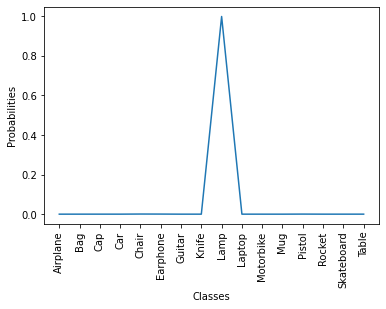

In [ ]:
# Three.js based visualizer
# visualizer = JVisualizer()

test_dataset_seg = PartDataset(root = DATA_FOLDER, classification = False, train = False, npoints = num_points, image=False)
# testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

# Basic inference and visualization loop
MAX_SAMPLES = 15

for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    # visualizer.clear()
    clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    cloud = o3.geometry.PointCloud()
    cloud.points = o3.utility.Vector3dVector(point_set)
    cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

    # perform inference in GPU
    points = Variable(point_set.unsqueeze(0))
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()
    pred_logsoft, _, _  = classifier(points)

    # move data back to cpu for visualization
    pred_logsoft_cpu = pred_logsoft.data.cpu().numpy().squeeze()
    pred_soft_cpu = np.exp(pred_logsoft_cpu)
    pred_class = np.argmax(pred_soft_cpu)
    label = list(classes_dict.keys())[pred_class]

    # let's visualize the input sample
    # visualizer.add_geometry(cloud)
    # visualizer.show()
    o3.visualization.draw_geometries([cloud])
    fn = work_dir + "output/" + label
    # save point cloud as image: does not work
    # o3.io.write_image(filename=fn, image=cloud)
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), pred_soft_cpu)
    plt.show()

    input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
          .format(label, pred_soft_cpu[pred_class]))